# Imports

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from collections import deque

%matplotlib inline

# Debug Option & Paths

In [2]:
debug = True
video_output = './output_videos/project_video_out_debug.mp4'
input_path = './test_videos/project_video.mp4'
image_name = 'test1'

# Camera Calibration

In [3]:
def camera_calibration():
    # Prepare object points 0,0,0 ... 8,5,0
    obj_pts = np.zeros((6*9,3), np.float32)
    obj_pts[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    # Stores all object points & img points from all images
    objpoints = []
    imgpoints = []

    # Get directory for all calibration images
    images = glob.glob('camera_cal/*.jpg')
    img = None
    for indx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        if ret == True:
            objpoints.append(obj_pts)
            imgpoints.append(corners)
    # Get image size
    img_size = (img.shape[1], img.shape[0])

    # Calibrate camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None,None)

    dst = cv2.undistort(img, mtx, dist, None, mtx)
    # Save camera calibration for later use
    dist_pickle = {}
    dist_pickle['mtx'] = mtx
    dist_pickle['dist'] = dist
    pickle.dump(dist_pickle, open('camera_cal_pickle.p', 'wb'))


camera_calibration()

# Import Camera Calibration Parameters

In [4]:
dist_pickle = "./camera_cal_pickle.p"
with open(dist_pickle, mode="rb") as f:
    CalData = pickle.load(f)
mtx, dist = CalData["mtx"], CalData["dist"]

# Line Class

In [5]:
class Lane_line:
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False

        # x and y values in last frame
        self.x = None
        self.y = None

        # x intercepts for average smoothing
        self.bottom_x = deque(maxlen=frame_num)
        self.top_x = deque(maxlen=frame_num)

        # Record last x intercept
        self.current_bottom_x = None
        self.current_top_x = None

        # Polynomial coefficients: x = A*y**2 + B*y + C
        self.A = deque(maxlen=frame_num)
        self.B = deque(maxlen=frame_num)
        self.C = deque(maxlen=frame_num)
        self.fit = None
        self.fitx = None
        self.fity = None

    def quick_sliding_window(self, nonzerox, nonzeroy, image):
        """
        Assuming in last frame, lane has been detected. Based on last x/y coordinates, quick search current lane.
        """
        x_inds = []
        y_inds = []
        # Form a 3D image
        out_img = np.dstack((image, image, image)) * 255
        # Check if the previous frame was detected
        if self.detected:
            # Set window top & bottom
            win_bottom = 720
            win_top = 630

            # loop from bottom of image to top
            while win_top >= 0:
                # Find the value of y (vertical center of the window)
                yval = np.mean([win_top, win_bottom])
                # Calculate the value of x (horizontal center of the window)
                xval = (np.median(self.A)) * yval ** 2 + (np.median(self.B)) * yval + (np.median(self.C))
                # Find non zero points in the range of the window
                x_idx = np.where((((xval - 50) < nonzerox)
                                  & (nonzerox < (xval + 50))
                                  & ((nonzeroy > win_top) & (nonzeroy < win_bottom))))
                x_window, y_window = nonzerox[x_idx], nonzeroy[x_idx]
                # Draw window
                cv2.rectangle(out_img, (int(xval - 50), win_top), (int(xval + 50), win_bottom),
                              (0, 255, 0), 2)
                # Add to x_inds & y_inds if there are non zero points in the window
                if np.sum(x_window) != 0:
                    np.append(x_inds, x_window)
                    np.append(y_inds, y_window)
                # Move up in the image
                win_top -= 90
                win_bottom -= 90
        # If there are no non zero points in all window then the quick search has failed
        if np.sum(x_inds) == 0:
            # If no lane pixels were detected then perform blind search
            self.detected = False
        return x_inds, y_inds, out_img

    def blind_sliding_window(self, nonzerox, nonzeroy, image):
        """
        Sliding window search method, start from blank.
        """
        x_inds = []
        y_inds = []
        # Form a 3D image
        out_img = np.dstack((image, image, image)) * 255
        # Check if the previous frame wasn't detected
        if self.detected is False:
            # Set window top & bottom
            win_bottom = 720
            win_top = 630
            # Find total histogram of the image
            histogram_complete = np.sum(image[200:, :], axis=0)
            # loop from bottom of image to top
            while win_top >= 0:
                # Find total histogram of the window
                histogram = np.sum(image[win_top:win_bottom, :], axis=0)
                # Check if it's the left or the right lane
                if self == right:
                    # Set the base of the window to the peak of the window histogram or image histogram if the first is
                    # always zero
                    base = (np.argmax(histogram[640:-60]) + 640) \
                    if np.argmax(histogram[640:-60]) > 0\
                    else (np.argmax(histogram_complete[640:]) + 640)
                else:
                    # Set the base of the window to the peak of the window histogram or image histogram if the first is
                    # always zero
                    base = np.argmax(histogram[:640]) \
                        if np.argmax(histogram[:640]) > 0 \
                        else np.argmax(histogram_complete[:640])
                # Find non zero points in the range of the window
                x_idx = np.where((((base - 50) < nonzerox) & (nonzerox < (base + 50))
                                  & ((nonzeroy > win_top) & (nonzeroy < win_bottom))))
                x_window, y_window = nonzerox[x_idx], nonzeroy[x_idx]
                # Draw window
                cv2.rectangle(out_img, (int(base - 50), win_top), (int(base + 50), win_bottom),
                              (0, 255, 0), 2)
                # Add to x_inds & y_inds if there are non zero points in the window
                if np.sum(x_window) != 0:
                    x_inds.extend(x_window)
                    y_inds.extend(y_window)
                # Move up in the image
                win_top -= 90
                win_bottom -= 90
        # If there are non zero points in the windows then the blind search succeeded
        if np.sum(x_inds) > 0:
            self.detected = True
        # Else return the points of the previous frame
        else:
            y_inds = self.y
            x_inds = self.x
        return x_inds, y_inds, out_img

    def sort_idx(self):
        """
        Sort x and y according to y index
        """
        sorted_idx = np.argsort(self.y)
        sorted_x_inds = self.x[sorted_idx]
        sorted_y_inds = self.y[sorted_idx]

        return sorted_x_inds, sorted_y_inds

    def get_intercepts(self):
        # Get lane intercept with image bottom
        bottom = self.fit[0] * 720 ** 2 + self.fit[1] * 720 + self.fit[2]
        # Get lane intercept with image top
        top = self.fit[2]
        return bottom, top

    def get_fit(self):
        """
        Based on searched x and y coordinates, polyfit with second order.
        Take median value in previous frames to smooth.
        """
        # Find initial curve parameters
        self.fit = np.polyfit(self.y, self.x, 2)

        # Get lane intercept with image boundaries
        self.current_bottom_x, self.current_top_x = self.get_intercepts()

        # Append to accumulative deque bottom_x & top_x
        self.bottom_x.append(self.current_bottom_x)
        self.top_x.append(self.current_top_x)

        # Set the current to median values of deque bottom_x & top_x
        self.current_bottom_x = np.median(self.bottom_x)
        self.current_top_x = np.median(self.top_x)

        # Add lane intercept points to x & y points
        self.x = np.append(self.x, self.current_bottom_x)
        self.x = np.append(self.x, self.current_top_x)
        self.y = np.append(self.y, 720)
        self.y = np.append(self.y, 0)

        # Sort
        self.x, self.y = self.sort_idx()

        # Find intermediate curve parameters
        self.fit = np.polyfit(self.y, self.x, 2)

        # Append to accumulative deque A, B, C
        self.A.append(self.fit[0])
        self.B.append(self.fit[1])
        self.C.append(self.fit[2])

        # Set y values
        self.fity = self.y

        # Find final curve parameters to median of accumulative deque A, B, C
        self.fit = [np.median(self.A), np.median(self.B), np.median(self.C)]

        # Calculate corresponding x values
        self.fitx = self.fit[0] * self.fity ** 2 + self.fit[1] * self.fity + self.fit[2]

        return self.fit, self.fitx, self.fity

# Global Variables

In [6]:
img_shape = (720, 1280)
img_size = [1280, 720]  # width, height

src = np.float32([[490, 482], [810, 482],
                  [1250, 720], [0, 720]])
dst = np.float32([[0, 0], [1280, 0],
                  [1250, 720], [40, 720]])
ploty = np.linspace(0, img_shape[0] - 1, img_shape[0])

# latest frames number of good detection
frame_num = 15

left = Lane_line()
right = Lane_line()

# Image

## Read Image

(-0.5, 1279.5, 719.5, -0.5)

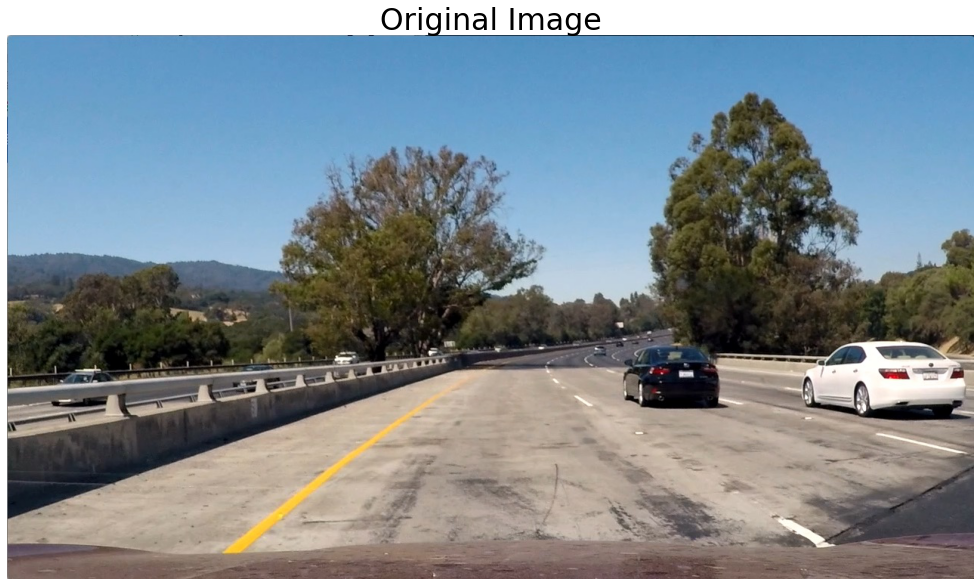

In [7]:
# Read Image
o_img = mpimg.imread(f'./test_images/{image_name}.jpg')

# Visualize Original Image
f, (ax1) = plt.subplots(1, 1, figsize=(20,10))
ax1.imshow(o_img)
ax1.set_title('Original Image', fontsize=30)
ax1.axis("off")

## Undistort Image

(-0.5, 1279.5, 719.5, -0.5)

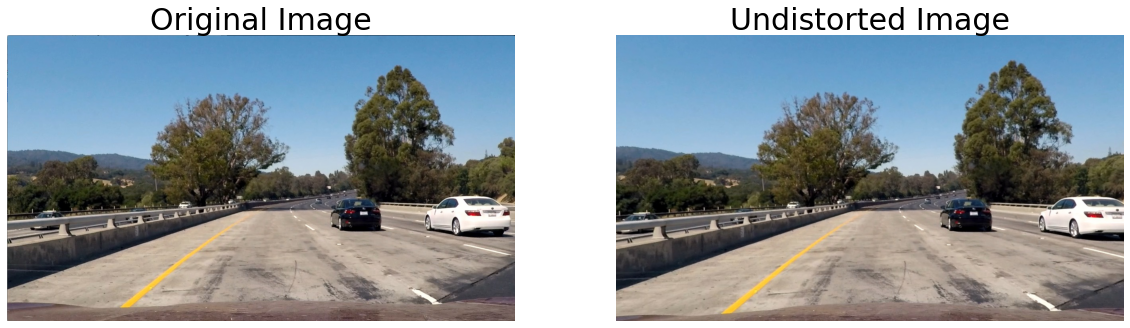

In [8]:
def undistort(img, mtx, dist):
    # transform to BGR to fit cv2.imread
    img_BGR = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    dst_img = cv2.undistort(img_BGR, mtx, dist, None, mtx)

    return cv2.cvtColor(dst_img, cv2.COLOR_BGR2RGB)

undist_img = undistort(o_img, mtx, dist)
# Visualize Undistorted Image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(o_img)
ax1.set_title('Original Image', fontsize=30)
ax1.axis("off")
ax2.imshow(undist_img)
ax2.set_title('Undistorted Image', fontsize=30)
ax2.axis("off")

## Warp Image

(-0.5, 1279.5, 719.5, -0.5)

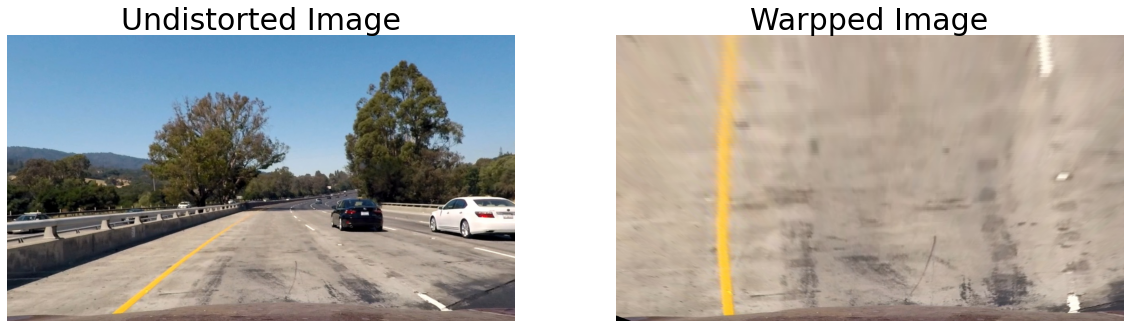

In [9]:
def warp(img):

    # Compute and apply perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    # keep same size as input image
    warped = cv2.warpPerspective(img, M, (1280, 720), flags=cv2.INTER_NEAREST)

    return warped

warped = warp(undist_img)

# Visualize Warp Image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(undist_img)
ax1.set_title('Undistorted Image', fontsize=30)
ax1.axis("off")
ax2.imshow(warped)
ax2.set_title('Warpped Image', fontsize=30)
ax2.axis("off")

## Filter Image

(-0.5, 1279.5, 719.5, -0.5)

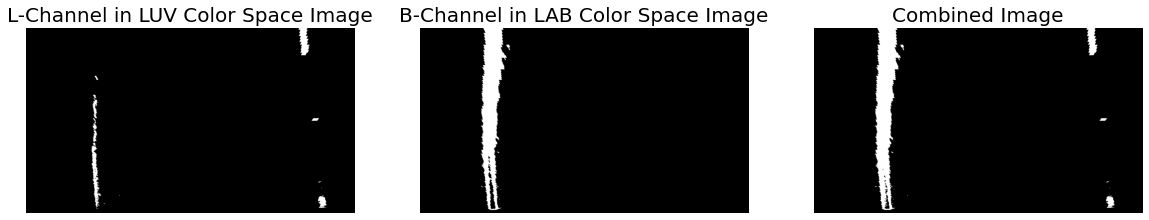

In [10]:
def luv_lab_filter(img, l_thresh=(195, 255), b_thresh=(140, 200)):
    l = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)[:, :, 0]
    l_bin = np.zeros_like(l)
    l_bin[(l >= l_thresh[0]) & (l <= l_thresh[1])] = 1

    b = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)[:, :, 2]
    b_bin = np.zeros_like(b)
    b_bin[(b >= b_thresh[0]) & (b <= b_thresh[1])] = 1

    combine = np.zeros_like(l)
    combine[(l_bin == 1) | (b_bin == 1)] = 1

    return l_bin, b_bin, combine

l_bin, b_bin, warped_binary = luv_lab_filter(warped, l_thresh=(215, 255), b_thresh=(145, 200))

# Visualize Filtered Image
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(l_bin, cmap='gray')
ax1.set_title('L-Channel in LUV Color Space Image', fontsize=20)
ax1.axis("off")
ax2.imshow(b_bin, cmap='gray')
ax2.set_title('B-Channel in LAB Color Space Image', fontsize=20)
ax2.axis("off")
ax3.imshow(warped_binary, cmap='gray')
ax3.set_title('Combined Image', fontsize=20)
ax3.axis("off")

## Sliding Window Image

(-0.5, 1279.5, 719.5, -0.5)

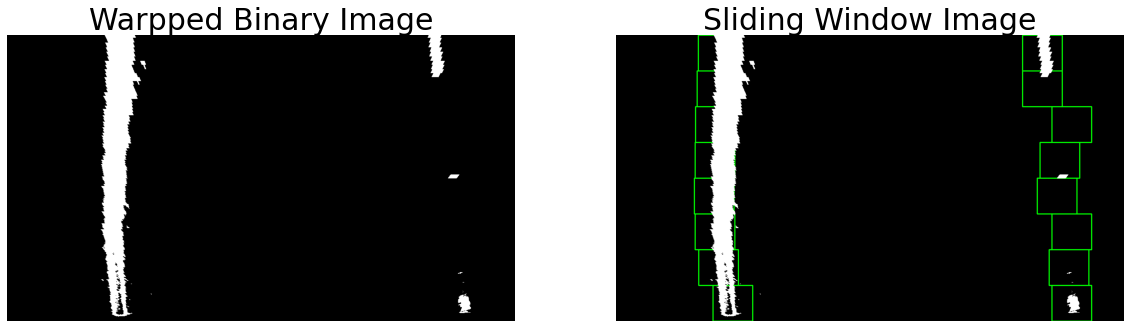

In [11]:
nonzerox, nonzeroy = np.nonzero(np.transpose(warped_binary))

if left.detected is True:
    leftx, lefty, out_img_left = left.quick_sliding_window(nonzerox, nonzeroy, warped_binary)
if right.detected is True:
    rightx, righty, out_img_right = right.quick_sliding_window(nonzerox, nonzeroy, warped_binary)
if left.detected is False:
    leftx, lefty, out_img_left = left.blind_sliding_window(nonzerox, nonzeroy, warped_binary)
if right.detected is False:
    rightx, righty, out_img_right = right.blind_sliding_window(nonzerox, nonzeroy, warped_binary)


out_combine = cv2.addWeighted(out_img_left, 1, out_img_right, 1, 0)

# Visualize Filtered Image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(warped_binary, cmap='gray')
ax1.set_title('Warpped Binary Image', fontsize=30)
ax1.axis("off")
ax2.imshow(out_combine)
ax2.set_title('Sliding Window Image', fontsize=30)
ax2.axis("off")

## Final Image

(-0.5, 1279.5, 719.5, -0.5)

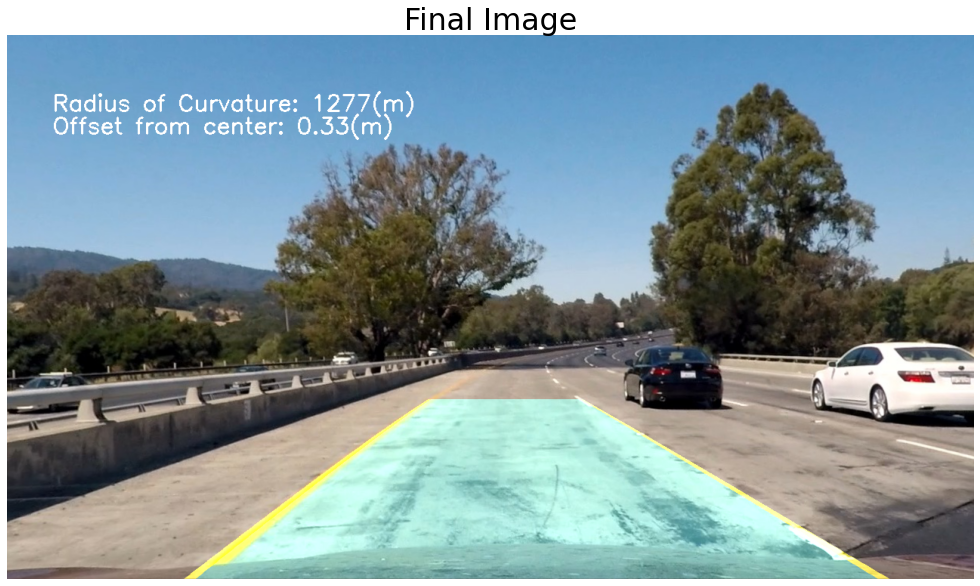

In [12]:
def car_pos(left_fit, right_fit):

    # Find lanes intersection with image bottom
    xleft_eval = left_fit[0] * np.max(ploty) ** 2 + left_fit[1] * np.max(ploty) + left_fit[2]
    xright_eval = right_fit[0] * np.max(ploty) ** 2 + right_fit[1] * np.max(ploty) + right_fit[2]

    # Find mean value
    xmean = np.mean((xleft_eval, xright_eval))

    # meters per pixel in y dimension
    ym_per_pix = 18 / 720

    # meters per pixel in x dimension
    xm_per_pix = 3.7 / abs(xleft_eval - xright_eval)

    # Find car offset from center (+: car in right; -: car in left side)
    offset = (img_shape[1]/2 - xmean) * xm_per_pix

    y_eval = np.max(ploty)
    # Find left Curvature
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    # Find left fit
    left_fit_cr = np.polyfit(ploty * ym_per_pix, left_fitx * xm_per_pix, 2)
    # Calculate the left lane Curvature at the bottom of the image
    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / \
                    np.absolute(2 * left_fit_cr[0])

    # Find right Curvature
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    # Find right fit
    right_fit_cr = np.polyfit(ploty * ym_per_pix, right_fitx * xm_per_pix, 2)
    # Calculate the right lane Curvature at the bottom of the image
    right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5) / \
                    np.absolute(2 * right_fit_cr[0])

    #Find mean
    mean_curv = np.mean([left_curverad, right_curverad])

    return offset, mean_curv

def draw(undist, left_fitx, lefty, right_fitx, righty):
    Minv = cv2.getPerspectiveTransform(dst, src)

    # Create an image to draw the lines on
    warp_zero = np.zeros(img_shape[0:2]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.flipud(np.transpose(np.vstack([left_fitx, lefty])))])

    pts_right = np.array([np.transpose(np.vstack([right_fitx, righty]))])

    pts = np.hstack((pts_left, pts_right))

    # Draw lines
    '''
    isClosed: Flag indicating whether the drawn polylines are closed or not. 
    If they are closed, the function draws a line from the last vertex of each curve to its first
    vertex.
    pts: Array of polygonal curves.
    '''

    # Draw the outlines of the lane to fill it later with the green shape
    cv2.polylines(color_warp, np.int_([pts]),
                  isClosed=False, color=(255, 255, 0), thickness=30)

    #   draw the green shape onto the warped image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 150, 150))

    # Warp the image back to original image space using inverse perspective matrix (Minv)
    new_warped_image = cv2.warpPerspective(color_warp, Minv, (img_shape[1], img_shape[0]))

    # Combine the result with the original image
    return cv2.addWeighted(undist, 1, new_warped_image, 0.5, 0)



left.y = np.array(lefty).astype(np.float32)
left.x = np.array(leftx).astype(np.float32)
right.y = np.array(righty).astype(np.float32)
right.x = np.array(rightx).astype(np.float32)

left_fit, left_fitx, left_fity = left.get_fit()
right_fit, right_fitx, right_fity = right.get_fit()

offset, mean_curv = car_pos(left_fit, right_fit)

result = draw(undist_img, left_fitx, left_fity, right_fitx, right_fity)

font = cv2.FONT_HERSHEY_SIMPLEX
text1 = 'Radius of Curvature: %d(m)'
text2 = 'Offset from center: %.2f(m)'
text3 = 'Radius of Curvature: Inf (m)'

if mean_curv < 3000:
    cv2.putText(result, text1 % (int(mean_curv)),
                              (60, 100), font, 1.0, (255, 255, 255), thickness=2)
else:
    cv2.putText(result, text3,
                (60, 100), font, 1.0, (255, 255, 255), thickness=2)
cv2.putText(result, text2 % (-offset),
                          (60, 130), font, 1.0, (255, 255, 255), thickness=2)

# Visualize Final Image
f, (ax1) = plt.subplots(1, 1, figsize=(20,10))
ax1.imshow(result)
ax1.set_title('Final Image', fontsize=30)
ax1.axis("off")

# Video

In [13]:
def vconcat_resize_min(im_list, interpolation=cv2.INTER_CUBIC):
    w_min = min(im.shape[1] for im in im_list)
    im_list_resize = [cv2.resize(im, (w_min, int(im.shape[0] * w_min / im.shape[1])), interpolation=interpolation)
                      for im in im_list]
    return cv2.vconcat(im_list_resize)

def hconcat_resize_min(im_list, interpolation=cv2.INTER_CUBIC):
    h_min = min(im.shape[0] for im in im_list)
    im_list_resize = [cv2.resize(im, (int(im.shape[1] * h_min / im.shape[0]), h_min), interpolation=interpolation)
                      for im in im_list]
    return cv2.hconcat(im_list_resize)

def concat_tile_resize(im_list_2d, interpolation=cv2.INTER_CUBIC):
    im_list_v = [hconcat_resize_min(im_list_h, interpolation=cv2.INTER_CUBIC) for im_list_h in im_list_2d]
    return vconcat_resize_min(im_list_v, interpolation=cv2.INTER_CUBIC)

def process_image(img):

    global mtx, dist, src, dst, debug

    undist_img = undistort(img, mtx, dist)

    warped = warp(img)

    l_bin, b_bin, warped_binary = luv_lab_filter(warped, l_thresh=(215, 255),
                                   b_thresh=(145, 200))
    nonzerox, nonzeroy = np.nonzero(np.transpose(warped_binary))

    if left.detected is True:
        leftx, lefty, out_img_left = left.quick_sliding_window(nonzerox, nonzeroy, warped_binary)
    if right.detected is True:
        rightx, righty, out_img_right = right.quick_sliding_window(nonzerox, nonzeroy, warped_binary)
    if left.detected is False:
        leftx, lefty, out_img_left = left.blind_sliding_window(nonzerox, nonzeroy, warped_binary)
    if right.detected is False:
        rightx, righty, out_img_right = right.blind_sliding_window(nonzerox, nonzeroy, warped_binary)


    out_combine = cv2.addWeighted(out_img_left, 1, out_img_right, 1, 0)

    left.y = np.array(lefty).astype(np.float32)
    left.x = np.array(leftx).astype(np.float32)
    right.y = np.array(righty).astype(np.float32)
    right.x = np.array(rightx).astype(np.float32)

    left_fit, left_fitx, left_fity = left.get_fit()
    right_fit, right_fitx, right_fity = right.get_fit()

    offset, mean_curv = car_pos(left_fit, right_fit)

    result = draw(undist_img, left_fitx, left_fity, right_fitx, right_fity)

    font = cv2.FONT_HERSHEY_SIMPLEX
    text1 = 'Radius of Curvature: %d(m)'
    text2 = 'Offset from center: %.2f(m)'
    text3 = 'Radius of Curvature: Inf (m)'

    if mean_curv < 3000:
        cv2.putText(result, text1 % (int(mean_curv)),
                                  (60, 100), font, 1.0, (255, 255, 255), thickness=2)
    else:
        cv2.putText(result, text3,
                    (60, 100), font, 1.0, (255, 255, 255), thickness=2)
    cv2.putText(result, text2 % (-offset),
                              (60, 130), font, 1.0, (255, 255, 255), thickness=2)

    if debug == True:
        warped_binary_3D = np.dstack((warped_binary, warped_binary, warped_binary)) * 255
        l_bin_3D = np.dstack((l_bin, l_bin, l_bin)) * 255
        b_bin_3D = np.dstack((b_bin, b_bin, b_bin)) * 255
        temp = vconcat_resize_min([undist_img, warped])
        result = concat_tile_resize([[result, temp], [l_bin_3D, b_bin_3D, warped_binary_3D, out_combine]])

    return result

clip1 = VideoFileClip(input_path)
final_clip = clip1.fl_image(process_image)
final_clip.write_videofile(video_output, audio=False)

Moviepy - Building video ./output_videos/project_video_out_debug.mp4.
Moviepy - Writing video ./output_videos/project_video_out_debug.mp4



Moviepy - Done !
Moviepy - video ready ./output_videos/project_video_out_debug.mp4
